# fig — compositional ftrs

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.chosen import *
from figures.analysis import *
from analysis.corrupt import perform_corruption_analysis
from analysis.clf import LogisticRegression

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
fig_dir = pjoin(fig_base_dir, 'iclr_oct02')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'convergence_mnist2imgnet.pdf',
    'mnist_to_imgnet',
    'ftrs_iP-VAE.png',
    'ftrs_P-VAE.png',
    'ood',
    'convergence_mse_mnist2omni.pdf',
    'rot',
    'convergence_mse_mnist2mnist.pdf',
    'recon'
]

## VAE: amort and iterative

In [4]:
mnist_to_load = selected_models_28x28(device)
selected_models = [
    'MNIST_<jacob|mlp>_(64,24.0)',
    'MNIST_<mlp|mlp>_(1,1.0)',
]
trainers = {}
for name in selected_models:
    tr, meta = load_model(**mnist_to_load[name])
    print(f"{name},\tcheckpoint: {meta['checkpoint']}")
    trainers[name] = tr

MNIST_<jacob|mlp>_(64,24.0),    checkpoint: 400

MNIST_<mlp|mlp>_(1,1.0),        checkpoint: 400

MNIST_<jacob|mlp>_(64,24.0)     . . .   iP-VAE, # params: 0.57

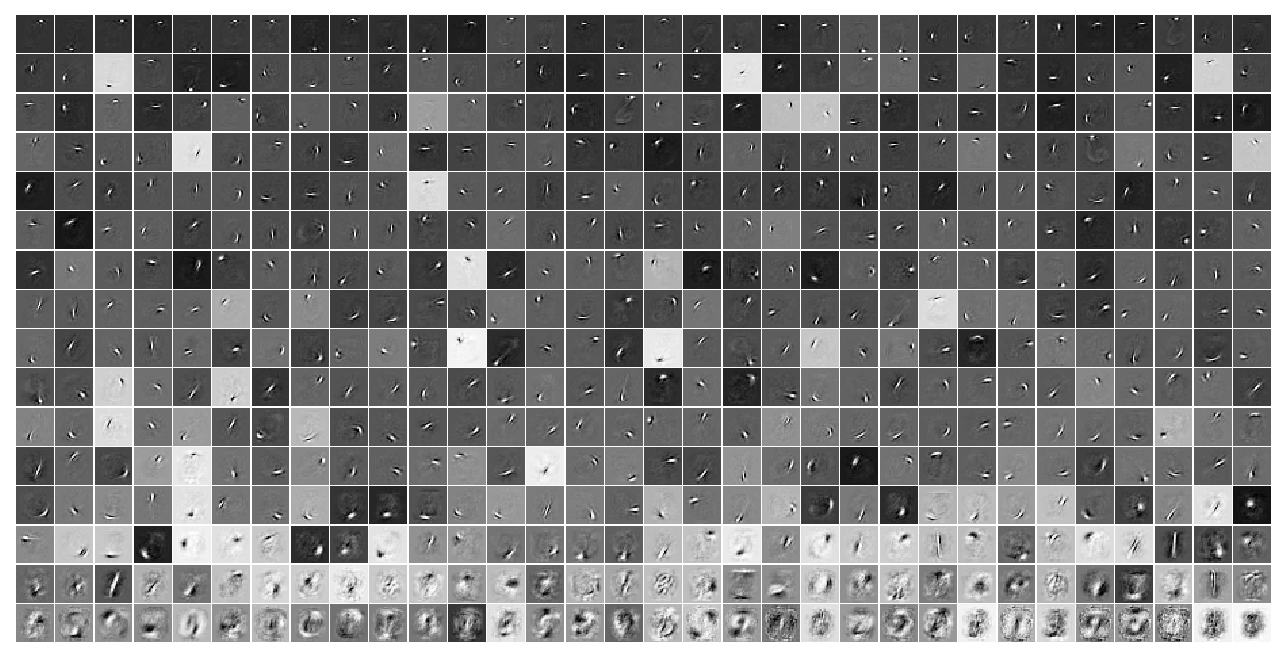

MNIST_<mlp|mlp>_(1,1.0) . . .   P-VAE,  # params: 1.13

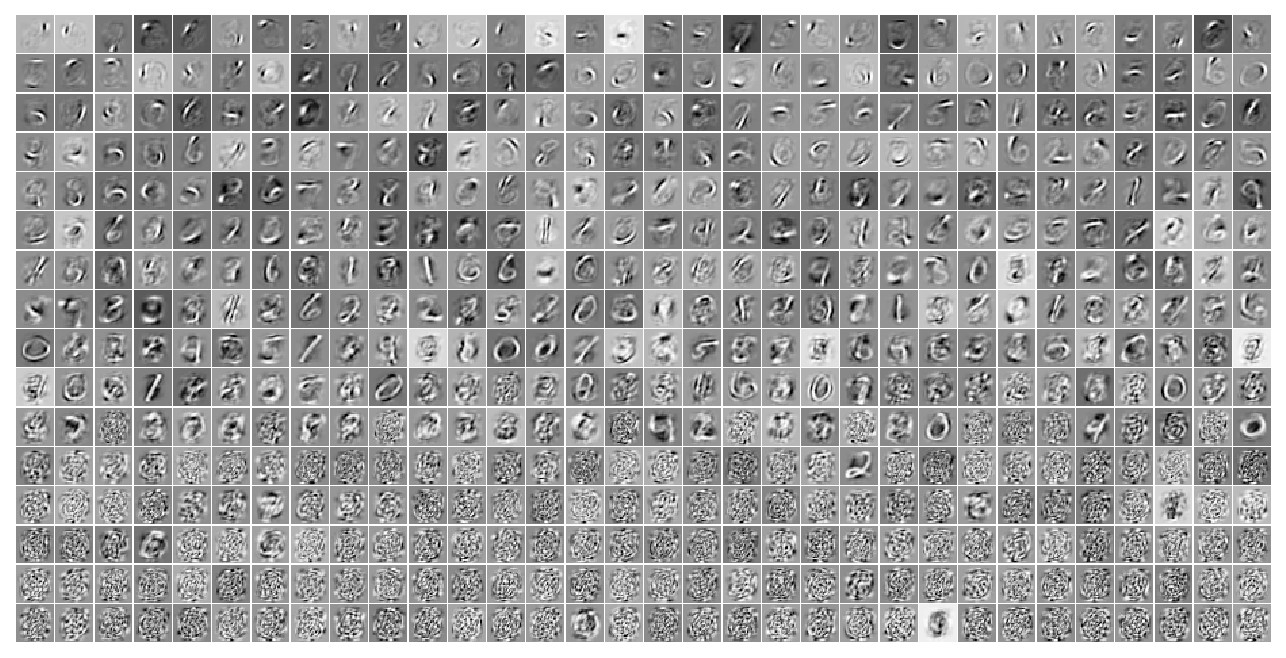

In [12]:
weights = {}
orders = {}

for name, tr in trainers.items():
    if tr.model.cfg.enc_type == 'jacob':
        paper_name = 'iP-VAE'
    else:
        paper_name = 'P-VAE'

    total_num_params = sum([
        p.nelement() for p
        in tr.parameters()
    ])
    print(f"{name}\t. . .\t{paper_name},\t# params: {total_num_params/1e6:0.2f}")
    
    w = tonp(tr.model.layer.get_weight())
    weights[paper_name] = w
    
    kurt = sp_stats.kurtosis(w, axis=1)
    order = np.argsort(kurt)[::-1]
    orders[paper_name] = order

    fig, ax = tr.model.show(order=order)
    fig_name = f"ftrs_{paper_name}.png"
    fig_name = pjoin(fig_dir, fig_name)
    fig.savefig(fig_name, **kws_fig)


In [6]:
save_obj(
    obj=weights,
    save_dir=tmp_dir,
    file_name='weights_mlp',
    mode='npy',
)

[PROGRESS] 'weights_mlp.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

## Dekel's code

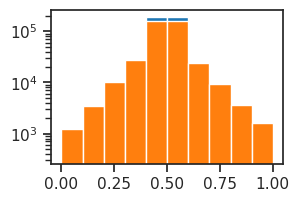

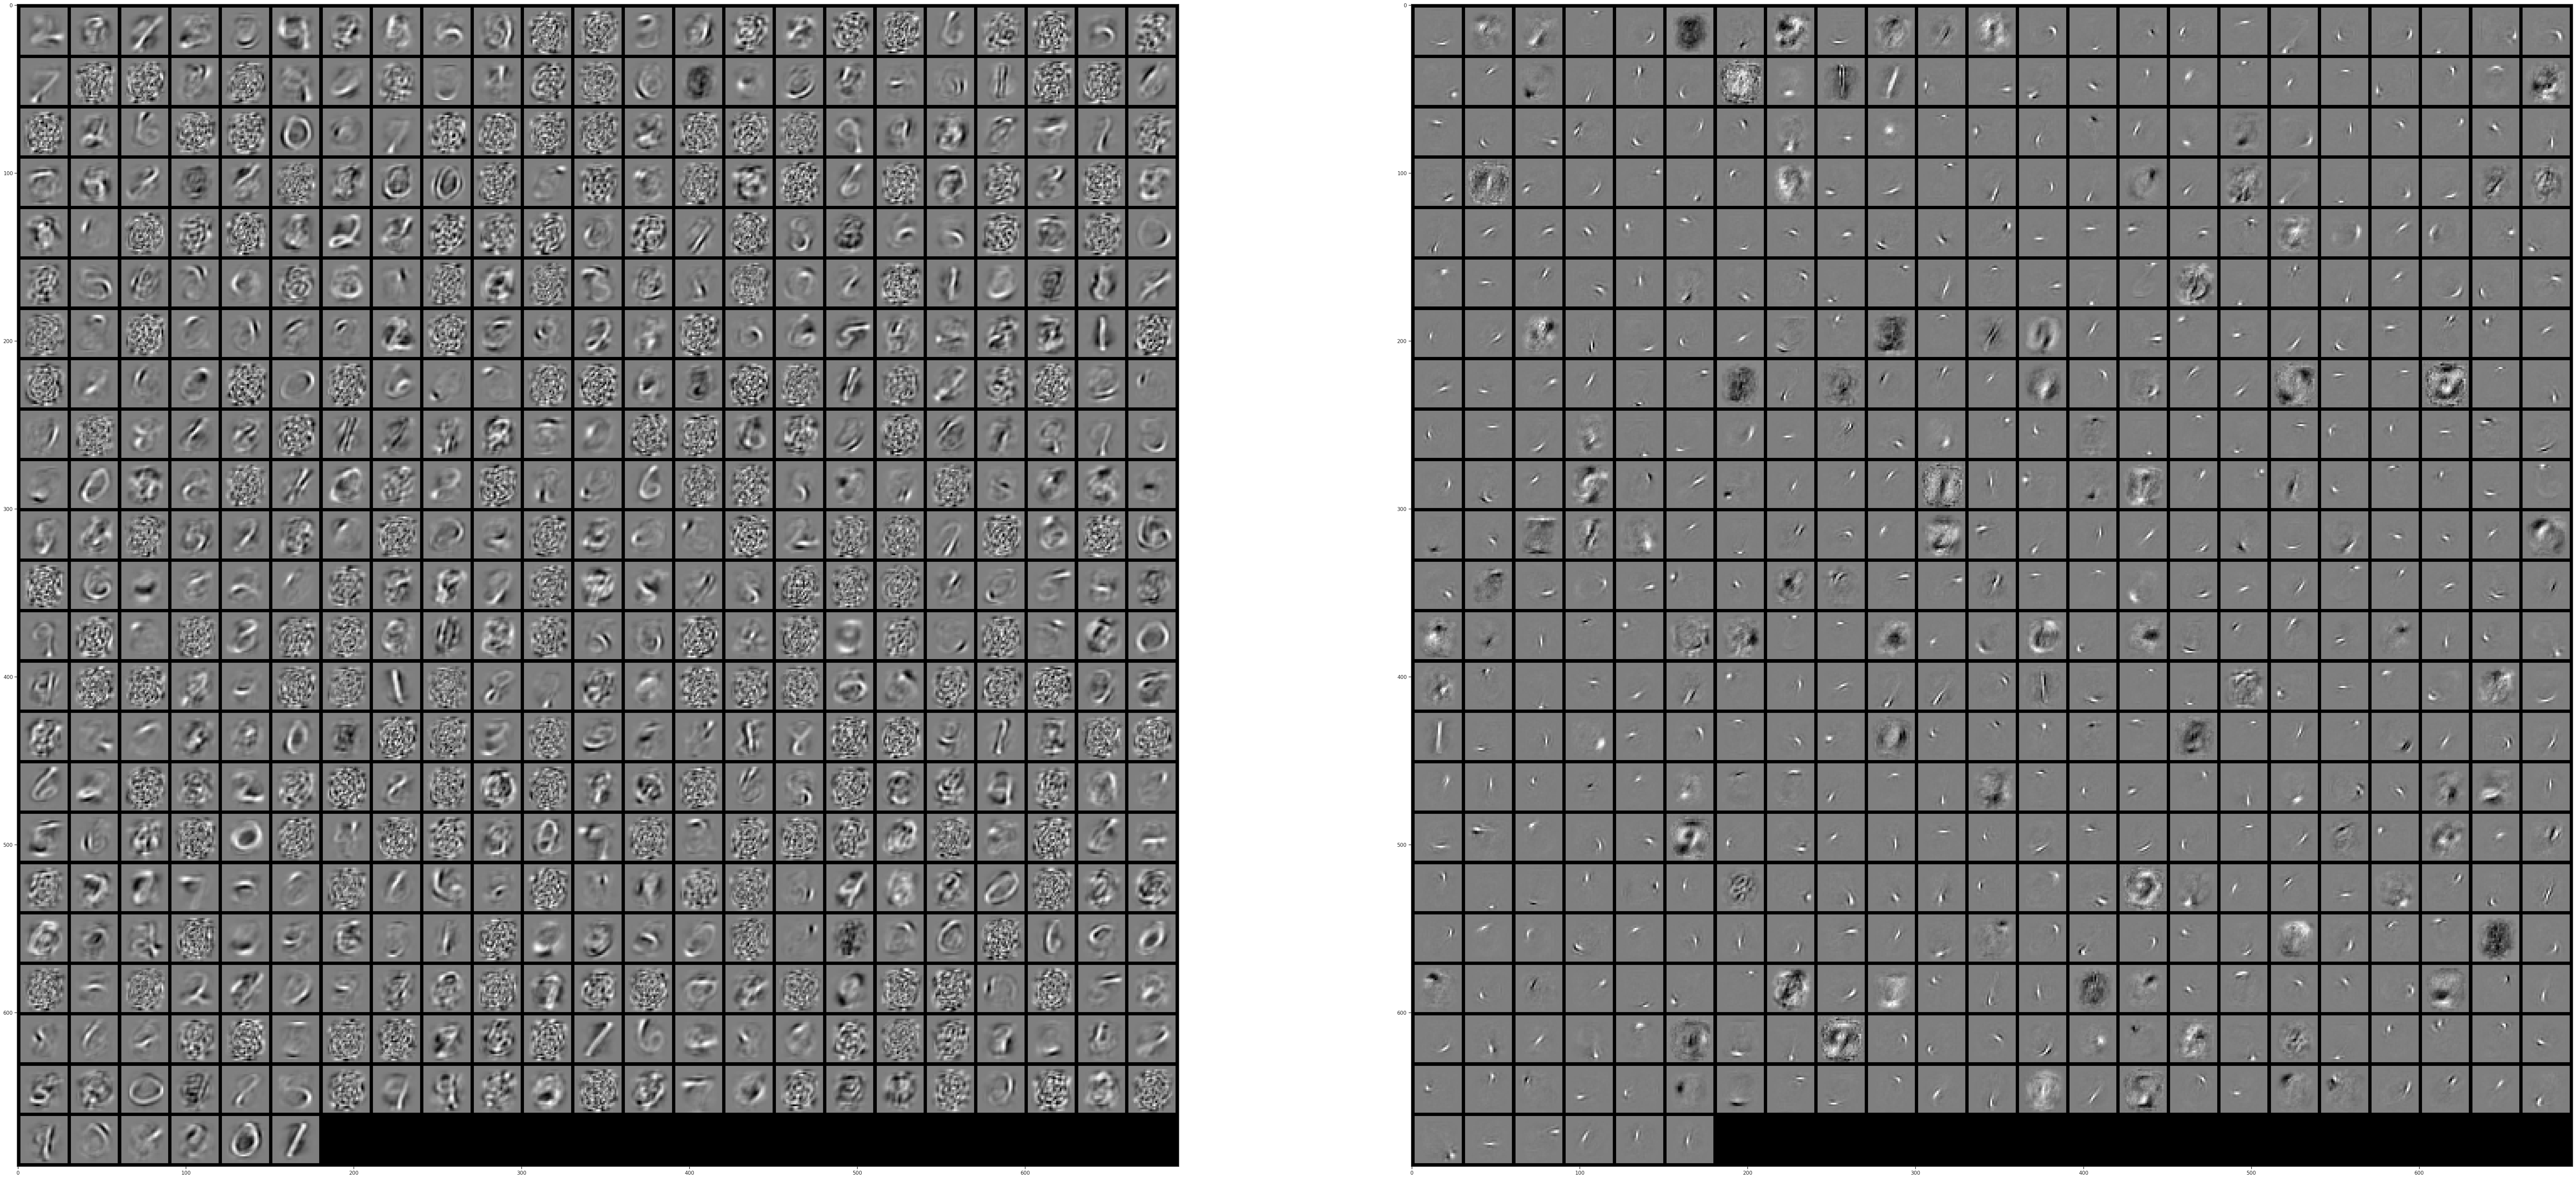

In [7]:
import numpy as np
import scipy
import scipy.stats
a = weights
mode = scipy.stats.mode(a['iP-VAE'], axis=1, keepdims=True).mode
ipvae = (a['iP-VAE']-np.median(a['iP-VAE'], axis=1, keepdims=True))
# ipvae = (ipvae / np.std(ipvae, axis=1, keepdims=True)).clip(-3, 3)
ipvae = (ipvae / np.max(np.abs(ipvae), 1, keepdims=True) * 0.5 + 0.5).reshape(-1, 1, 28, 28)
mode = scipy.stats.mode(a['P-VAE'], axis=1, keepdims=True).mode
pvae = (a['P-VAE']-np.median(a['P-VAE'], axis=1, keepdims=True))
# pvae = (pvae / np.std(pvae, axis=1, keepdims=True)).clip(-3, 3)
pvae = (pvae / np.max(np.abs(pvae), 1, keepdims=True) * 0.5 + 0.5).reshape(-1, 1, 28, 28)
# %%
import matplotlib.pyplot as plt
plt.hist(ipvae.flatten(), log=True)
plt.hist(pvae.flatten(), log=True)
# %%
import torchvision
import torch
grid_pvae = torchvision.utils.make_grid(torch.tensor(pvae), nrow=23)#, scale_each=True, range=(0, 1), normalize=True)
grid_ipvae = torchvision.utils.make_grid(torch.tensor(ipvae), nrow=23)#, scale_each=True, range=(0, 1), normalize=True)
# %%
plt.figure(figsize=(100, 50))
plt.subplot(1, 2, 1)
plt.imshow(grid_pvae.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(grid_ipvae.permute(1, 2, 0))
# %%



In [8]:
ipvae.shape

(512, 1, 28, 28)

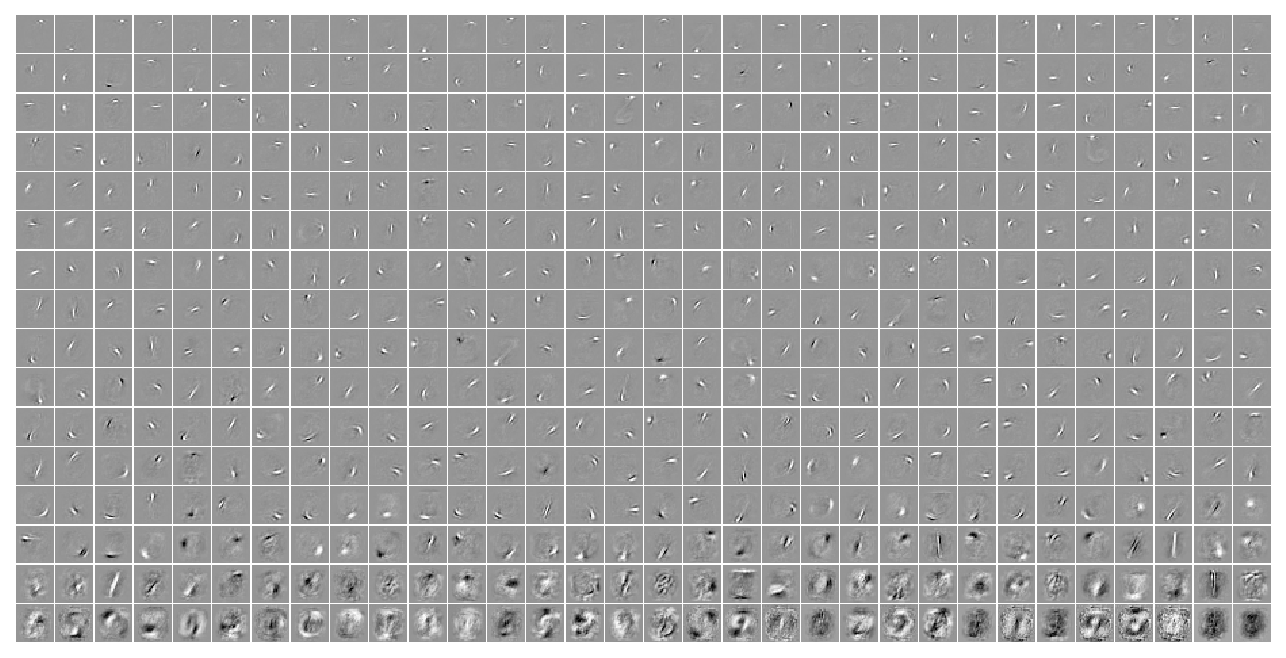

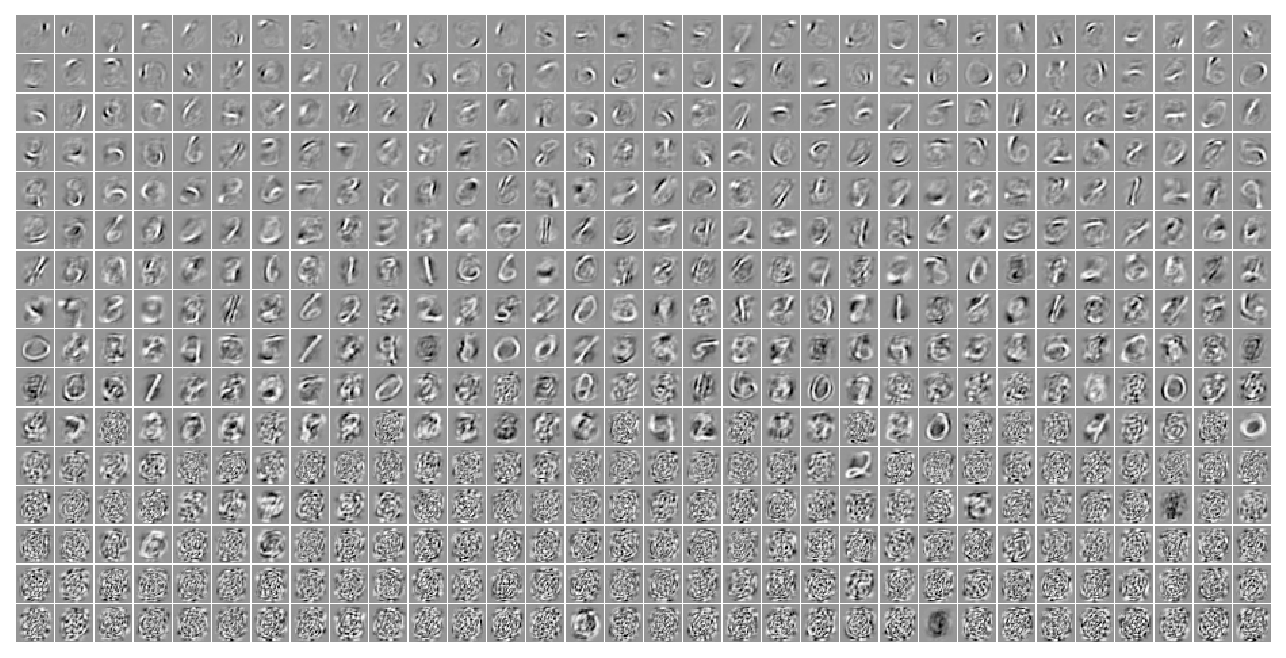

In [15]:
paper_name = 'iP-VAE'
fig, ax = plot_weights(ipvae[orders[paper_name]], nrows=16, method='none', vmin=0, vmax=1)
fig_name = f"ftrs_dekel_{paper_name}.png"
fig_name = pjoin(fig_dir, fig_name)
fig.savefig(fig_name, **kws_fig)

paper_name = 'P-VAE'
fig, ax = plot_weights(pvae[orders[paper_name]], nrows=16, method='none', vmin=0, vmax=1)
fig_name = f"ftrs_dekel_{paper_name}.png"
fig_name = pjoin(fig_dir, fig_name)
fig.savefig(fig_name, **kws_fig)